# **Phase 1 : Data Setup & Loading for MovieLens 1M**

In [ ]:
import importlib.util, subprocess, sys

# Ensure correct numpy & surprise version
subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", "numpy==1.26.4", "scikit-surprise", "--no-cache-dir", "--force-reinstall"])


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', '--quiet', 'numpy==1.26.4', 'scikit-surprise', '--no-cache-dir', '--force-reinstall'], returncode=0)

## Loading Data Files

In [ ]:


import pandas as pd
import re

def clean_title(title):
    """
    Reorder titles like "Shawshank Redemption, The (1994)" → "The Shawshank Redemption (1994)"
    """
    match = re.match(r'^(.*),\s(The|An|A)\s\((\d{4})\)$', title)
    if match:
        main, article, year = match.groups()
        return f"{article} {main} ({year})"
    return title

# ---------- Load Datasets ----------
movies = pd.read_csv("movies.dat", sep="::", engine='python', encoding="latin-1",
                     names=["movieId","title","genres"])
movies['title'] = movies['title'].apply(clean_title)

ratings = pd.read_csv("ratings.dat", sep="::", engine='python', encoding="latin-1",
                      names=["userId","movieId","rating","timestamp"])

users = pd.read_csv("users.dat", sep="::", engine='python', encoding="latin-1",
                    names=["userId","gender","age","occupation","zipcode"])

# ---------- Preview Data ----------
from IPython.display import display

def styled_table(df, title):
    styled = df.head().style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#222222'),
                                      ('color', 'white'),
                                      ('font-size', '14px'),
                                      ('text-align', 'center')]},
         {'selector': 'td', 'props': [('background-color', '#f9f9f9'),
                                      ('color', '#333333'),
                                      ('font-size', '13px')]}]
    ).set_properties(**{'text-align': 'center'})
    display(styled.set_caption(title))

styled_table(movies, "Sample Movies Data")
styled_table(ratings, "Sample Ratings Data")
styled_table(users, "Sample Users Data")

import matplotlib.pyplot as plt
import seaborn as sns


# Heatmap in lightmode
import plotly.express as px

sample = ratings.sample(5000, random_state=42)  # sample for performance
fig = px.scatter(
    sample, x="movieId", y="userId", color="rating",
    color_continuous_scale="Viridis",
    title="User-Movie Rating Distribution (Sampled 5,000 Ratings)",
    labels={"movieId": "Movies", "userId": "Users", "rating": "Rating"}
)
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.show()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,userId,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# **Phase 2: Exploratory Data Analysis (EDA)**

Step 1: Importing visual libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#for clean plots
sns.set(style="whitegrid")

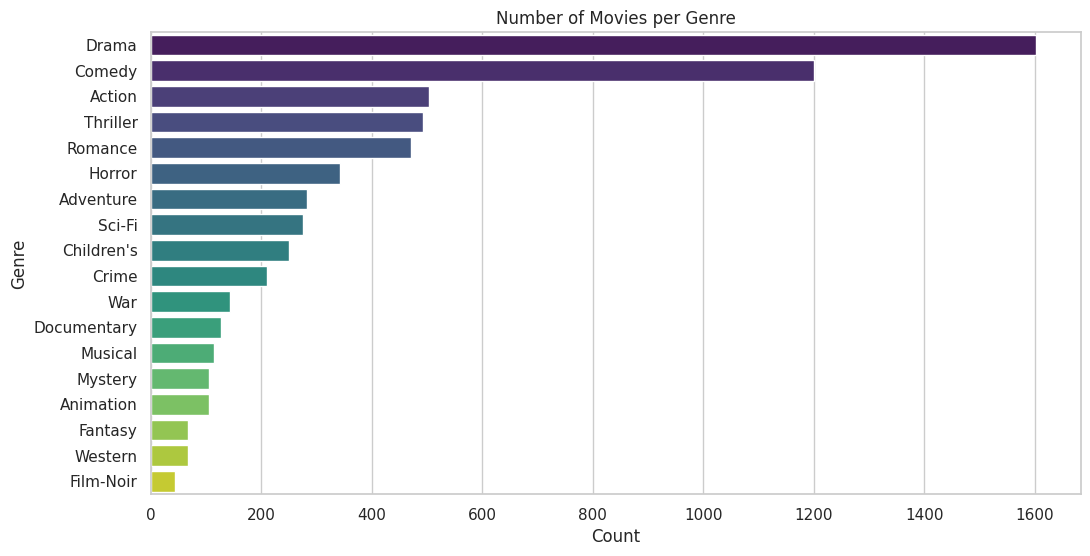

In [ ]:
from collections import Counter

# Split genres and count them
genre_list = movies['genres'].str.split('|').sum()
genre_counts = Counter(genre_list)

# Convert to DataFrame for plotting
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Count', y='Genre', data=genre_df, palette='viridis', hue='Genre', legend=False)
plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

 Step 3 : Ratings Distribution

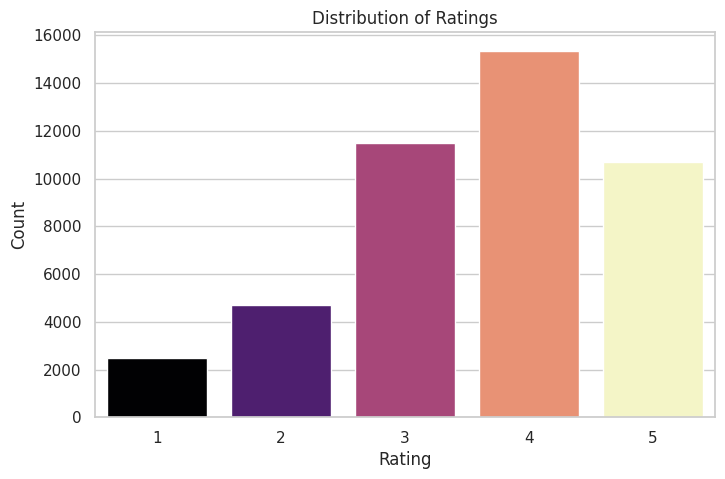

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='rating',data=ratings,palette='magma', hue='rating',legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Step 4 : Most-Rated Movies

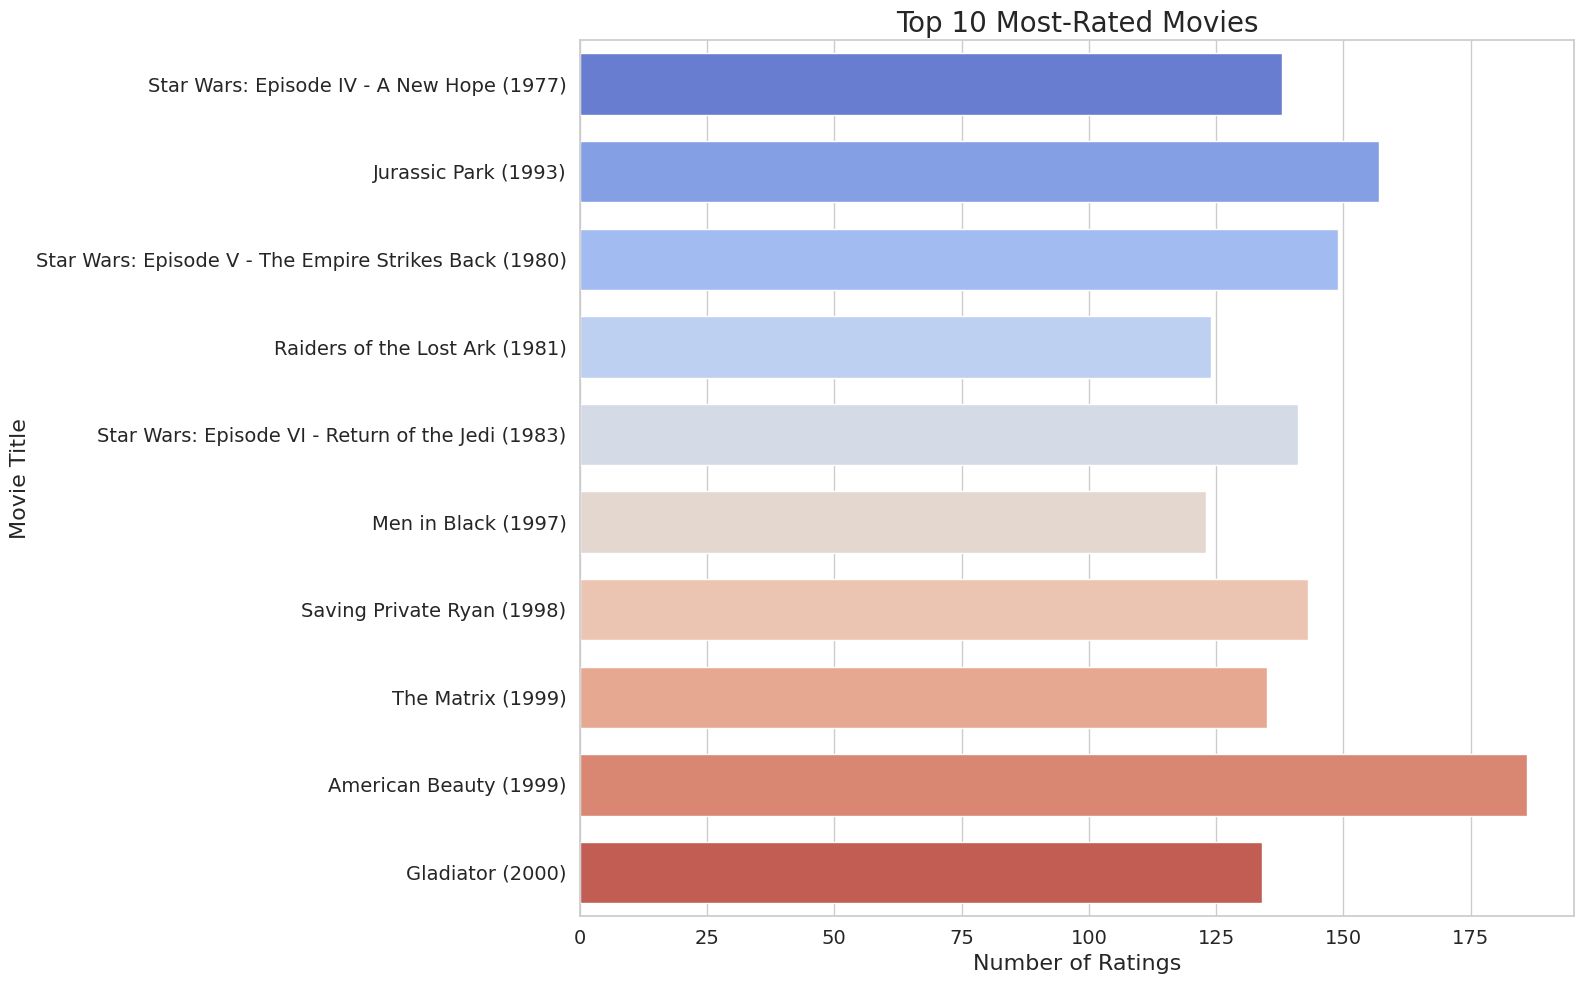

In [ ]:
movie_rating_counts = ratings.groupby('movieId').size().reset_index(name='rating_count')
most_rated = movie_rating_counts.sort_values(by='rating_count', ascending=False).head(10)
top_movies = movies[movies['movieId'].isin(most_rated['movieId'])]

# Merge to get titles
top_movies = top_movies.merge(most_rated, on='movieId')

plt.figure(figsize=(16,10))
sns.barplot(x='rating_count', y='title', data=top_movies, palette='coolwarm',
    hue='title',       # Add hue
    legend=False,      # Hide legend
    width=0.7
)
plt.title('Top 10 Most-Rated Movies', fontsize=20)
plt.xlabel('Number of Ratings', fontsize=16)
plt.ylabel('Movie Title', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


Step 5 : Highest-Rated Movies (with min 100 ratings)

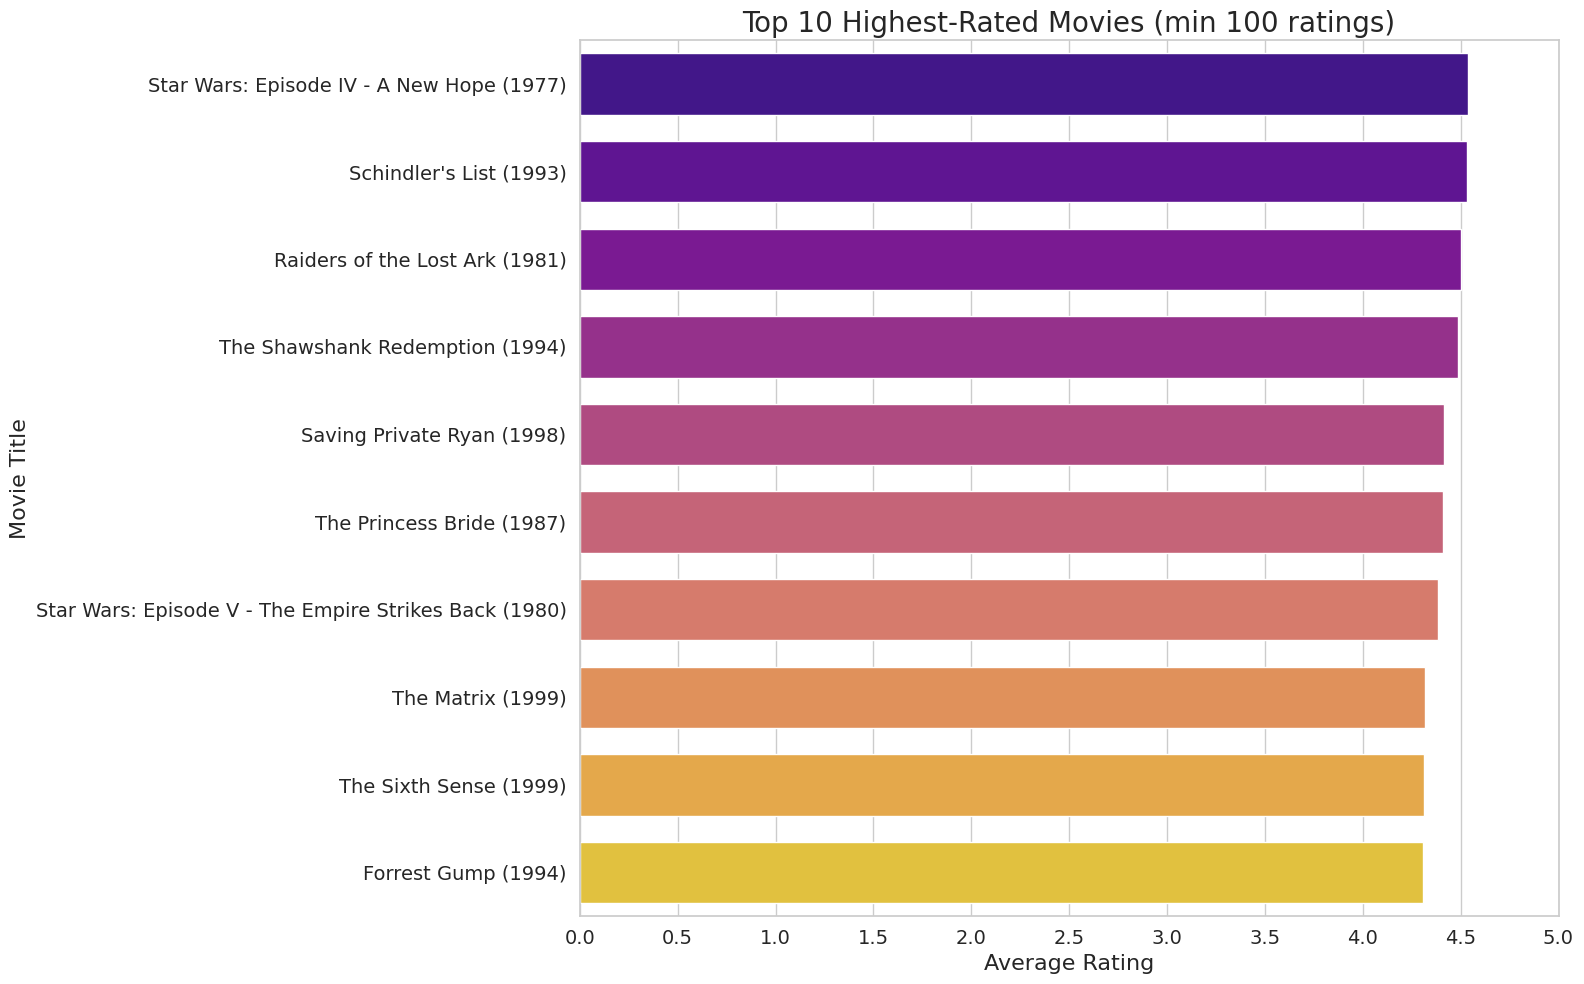

In [ ]:
movie_avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_counts = ratings.groupby('movieId').size().reset_index(name='rating_count')

movie_stats = movie_avg_ratings.merge(movie_counts, on='movieId')
movie_stats = movie_stats[movie_stats['rating_count'] >= 100]  # filter
top_rated = movie_stats.sort_values(by='rating', ascending=False).head(10)
top_rated = top_rated.merge(movies, on='movieId')

import numpy as np

plt.figure(figsize=(16,10))
sns.barplot(
    x='rating',
    y='title',
    data=top_rated,
    palette='plasma',
    hue='title',
    legend=False,
    width=0.7
)

# Bigger & clearer text
plt.title('Top 10 Highest-Rated Movies (min 100 ratings)', fontsize=20)
plt.xlabel('Average Rating', fontsize=16)
plt.ylabel('Movie Title', fontsize=16)
plt.xticks(np.arange(0, 5.5, 0.5), fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()






In [ ]:
# ==============================================================================
# FINAL HELPER FUNCTIONS
# Run this cell once to define all necessary functions for the rest of the project.
# ==============================================================================

from surprise import SVD, Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import pandas as pd
import numpy as np

# --- Display Function ---
def styled_table(df, title):
    styled = df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#222222'), ('color', 'white'), ('font-size', '14px'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('background-color', '#f9f9f9'), ('color', '#333333'), ('font-size', '13px')]}]
    ).set_properties(**{'text-align': 'center'})
    display(styled.set_caption(title))

# --- Metric Functions ---
def precision_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]; return len(set(recommended_k) & set(relevant)) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]; return len(set(recommended_k) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    dcg = sum(1 / np.log2(i + 2) for i, movie in enumerate(recommended_k) if movie in relevant)
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# --- Leave-One-Out Data Split Function ---
def build_leave_one_out(ratings_df, min_rating=4):
    print("Building leave-one-out dataset...")
    test_rows, train_rows = [], []
    for user_id, group in ratings_df.groupby('userId'):
        high_rated = group[group['rating'] >= min_rating]
        if not high_rated.empty:
            test_row = high_rated.sample(1, random_state=42)
            test_rows.append(test_row)
            train_rows.append(group.drop(test_row.index))
        else:
            train_rows.append(group)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows) if test_rows else pd.DataFrame(columns=ratings_df.columns)
    print("Finished building dataset.")
    return train_df, test_df

# --- Single User Evaluation Function ---
def evaluate_single_user(model_type, user_id, k=10, alpha=0.7):
    # Find the single held-out movie for this user from the test set
    user_test_entry_df = loo_test[(loo_test['userId'] == user_id) & (loo_test['rating'] >= 4)]

    if user_test_entry_df.empty:
        return {"Precision@K": 0, "Recall@K": 0, "NDCG@K": 0} # Return 0 if no test item

    heldout_movie = user_test_entry_df.iloc[0]['movieId']

    # Get recommendations based on the specified model type
    if model_type == 'svd':
        recommended = get_top_n_recommendations(svd_loo, user_id, n=k)['movieId'].tolist()
    elif model_type == 'content':
        recommended = fast_content_recommendations(user_id, train_ratings, n=k)
    elif model_type == 'hybrid':
        recommended = fast_hybrid_recommendations(user_id, svd_loo, train_ratings, alpha=alpha, n=k)

    # Calculate metrics for this single user
    hits = set(recommended) & {heldout_movie}
    precision = len(hits) / k
    recall = len(hits) / 1
    rank = recommended.index(heldout_movie) + 1 if heldout_movie in recommended else None
    ndcg = 1 / np.log2(rank + 1) if rank else 0

    return {"Precision@K": precision, "Recall@K": recall, "NDCG@K": ndcg}

# **Phase 3: Model & Helper Function Definitions**

In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# --- Helper: Scoring Functions ---
def precision_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    dcg = sum(1 / np.log2(i + 2) for i, movie in enumerate(recommended_k) if movie in relevant)
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# --- Recommendation Function: Content-Based ---
def content_recommendations(user_id, ratings_df, movie_df, similarity_matrix, movieid_to_idx, idx_to_movieid, n=10):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0:
        liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values
    if len(liked_movies) == 0:
        return []

    liked_indices = [movieid_to_idx.get(mid) for mid in liked_movies if mid in movieid_to_idx]
    if not liked_indices: return []

    sim_scores = similarity_matrix[liked_indices].mean(axis=0)

    rated_indices = [movieid_to_idx.get(mid) for mid in user_ratings['movieId'].values if mid in movieid_to_idx]
    sim_scores[rated_indices] = -1

    top_indices = np.argsort(sim_scores)[::-1][:n]
    top_movie_ids = [idx_to_movieid[i] for i in top_indices]
    return top_movie_ids

# --- Recommendation Function: Hybrid ---
def hybrid_recommendations(user_id, svd_model, ratings_df, movie_df, similarity_matrix, movieid_to_idx, idx_to_movieid, alpha=0.7, n=10):
    try:
        inner_uid = svd_model.trainset.to_inner_uid(user_id)
    except ValueError:
        return content_recommendations(user_id, ratings_df, movie_df, similarity_matrix, movieid_to_idx, idx_to_movieid, n)

    # SVD Scores
    user_svd_scores = svd_model.pu[inner_uid] @ svd_model.qi.T + svd_model.bi + svd_model.bu[inner_uid] + svd_model.trainset.global_mean

    # Content Scores
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0:
        liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values
    if len(liked_movies) == 0:
        return [] # Can't generate content score, return empty

    liked_indices = [movieid_to_idx.get(mid) for mid in liked_movies if mid in movieid_to_idx]
    if not liked_indices: return []
    content_scores = similarity_matrix[liked_indices].mean(axis=0)

    # Normalize and Blend
    s_min, s_max = user_svd_scores.min(), user_svd_scores.max()
    c_min, c_max = content_scores.min(), content_scores.max()
    norm_svd = (user_svd_scores - s_min) / (s_max - s_min) if (s_max - s_min) > 0 else 0
    norm_content = (content_scores - c_min) / (c_max - c_min) if (c_max - c_min) > 0 else 0

    hybrid_scores = alpha * norm_svd + (1 - alpha) * norm_content

    # Mask and Rank
    rated_indices = [movieid_to_idx.get(mid) for mid in user_ratings['movieId'].values if mid in movieid_to_idx]
    hybrid_scores[rated_indices] = -1

    top_indices = np.argsort(hybrid_scores)[::-1][:n]
    top_movie_ids = [idx_to_movieid[i] for i in top_indices]
    return top_movie_ids

print("All helper and recommendation functions are defined.")

All helper and recommendation functions are defined.


# **PHASE 4: FINAL DEMONSTRATION**

### Model Output

In [ ]:
# --- Imports needed for this cell ---
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np


# 1. Train a final SVD model on ALL available data
print("Training a final SVD model on all data for demonstration...")
reader = Reader(rating_scale=(1, 5))
full_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
final_trainset = full_data.build_full_trainset()

svd_final = SVD(random_state=42)
svd_final.fit(final_trainset)


# 2. Build the final Content-Based components on ALL data
print("Building final content-based model components...")
# Align movies dataframe with the items the final SVD model knows about
final_movie_ids = [final_trainset.to_raw_iid(i) for i in range(final_trainset.n_items)]
movies_final = movies[movies['movieId'].isin(final_movie_ids)].reset_index(drop=True)

# Create the final mappings and similarity matrix
movie_id_to_index_final = {mid: idx for idx, mid in enumerate(movies_final['movieId'])}
index_to_movie_id_final = {idx: mid for mid, idx in movie_id_to_index_final.items()}
movie_ids_array_final = movies_final['movieId'].values

genre_matrix_final = movies_final['genres'].str.get_dummies(sep='|')
genre_similarity_final = cosine_similarity(genre_matrix_final)


# 3. Generate and display recommendations for a sample user
user_id = 12   # You can change this ID to see recommendations for different users
alpha = 0.7    # The blending weight we evaluated
k = 10         # The number of recommendations to show

print(f"\n--- Final Recommendations for User {user_id} using the Hybrid Model (α={alpha}) ---")

# Use the 'hybrid_recommendations' function defined in a previous phase
final_recs_ids = hybrid_recommendations(
    user_id=user_id,
    svd_model=svd_final,
    ratings_df=ratings, # Use the full ratings df for the user's profile
    movie_df=movies_final,
    similarity_matrix=genre_similarity_final,
    movieid_to_idx=movie_id_to_index_final,
    idx_to_movieid=index_to_movie_id_final,
    alpha=alpha,
    n=k
)

# Display the results in a styled table
# THE FIX: This line now selects ONLY the desired columns for the final table
final_recs_df = movies[movies['movieId'].isin(final_recs_ids)][['movieId', 'title', 'genres']]

# This calls the corrected styled_table function (without .head())
styled_table(final_recs_df, f"Top {k} Hybrid Recommendations for User {user_id}")

Training a final SVD model on all data for demonstration...
Building final content-based model components...

--- Final Recommendations for User 12 using the Hybrid Model (α=0.7) ---


,movieId,title,genres
13,14,Nixon (1995),Drama
258,261,Little Women (1994),Drama
311,314,The Secret of Roan Inish (1994),Drama
881,893,Mother Night (1996),Drama
942,954,Mr. Smith Goes to Washington (1939),Drama
1226,1246,Dead Poets Society (1989),Drama
1344,1365,Ridicule (1996),Drama
1647,1694,The Apostle (1997),Drama
1656,1704,Good Will Hunting (1997),Drama
1892,1961,Rain Man (1988),Drama


### MULTIPLE USER HYBRID EVALUATION

In [ ]:
# --- Imports ---
from surprise import SVD, Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import pandas as pd
import numpy as np

# --- Helper Functions ---
def styled_table(df, title):
    styled = df.style.set_table_styles(
        [{'selector': 'th', 'props': [('background-color', '#222222'), ('color', 'white'), ('font-size', '14px'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('background-color', '#f9f9f9'), ('color', '#333333'), ('font-size', '13px')]}]
    ).set_properties(**{'text-align': 'center'})
    display(styled.set_caption(title))

def precision_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]; return len(set(recommended_k) & set(relevant)) / k if k > 0 else 0

def recall_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]; return len(set(recommended_k) & set(relevant)) / len(relevant) if relevant else 0

def ndcg_at_k(recommended, relevant, k=10):
    recommended_k = recommended[:k]
    dcg = sum(1 / np.log2(i + 2) for i, movie in enumerate(recommended_k) if movie in relevant)
    ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# --- Data Splitting and Model Training ---
def build_leave_one_out(ratings_df, min_rating=4):
    print("Building leave-one-out dataset...")
    test_rows, train_rows = [], []
    for user_id, group in ratings_df.groupby('userId'):
        high_rated = group[group['rating'] >= min_rating]
        if not high_rated.empty:
            test_row = high_rated.sample(1, random_state=42)
            test_rows.append(test_row)
            train_rows.append(group.drop(test_row.index))
        else:
            train_rows.append(group)
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows) if test_rows else pd.DataFrame(columns=ratings_df.columns)
    return train_df, test_df

train_ratings, loo_test = build_leave_one_out(ratings)

reader_loo = Reader(rating_scale=(1, 5))
data_loo = Dataset.load_from_df(train_ratings[['userId','movieId','rating']], reader_loo)
trainset_loo = data_loo.build_full_trainset()
svd_loo = SVD(random_state=42)
svd_loo.fit(trainset_loo)
print("SVD model trained.")

# --- Content-Based Components ---
print("Building content-based model components...")
train_movie_ids = [int(svd_loo.trainset.to_raw_iid(i)) for i in range(svd_loo.trainset.n_items)]
movies_train = movies[movies['movieId'].isin(train_movie_ids)].reset_index(drop=True)
movie_id_to_index = {mid: idx for idx, mid in enumerate(movies_train['movieId'])}
index_to_movie_id = {idx: mid for mid, idx in movie_id_to_index.items()}
genre_matrix = movies_train['genres'].str.get_dummies(sep='|')
genre_similarity = cosine_similarity(genre_matrix)

# --- Recommendation Functions ---
def fast_hybrid_recommendations(user_id, svd_model, ratings_df, alpha=0.7, n=10):
    try: inner_uid = svd_model.trainset.to_inner_uid(user_id)
    except ValueError: return []
    user_vector = svd_model.pu[inner_uid]
    item_vectors = svd_model.qi
    svd_scores = user_vector @ item_vectors.T + svd_model.bi + svd_model.bu[inner_uid] + svd_model.trainset.global_mean
    svd_movie_ids = [svd_model.trainset.to_raw_iid(iid) for iid in range(svd_model.trainset.n_items)]
    scores_df = pd.DataFrame({'movieId': svd_movie_ids, 'svd_score': svd_scores})
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0: liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values
    if len(liked_movies) == 0: return []
    liked_indices = [movie_id_to_index.get(mid) for mid in liked_movies if mid in movie_id_to_index]
    if not liked_indices: return []
    content_scores = genre_similarity[liked_indices].mean(axis=0)
    content_df = pd.DataFrame({'movieId': movies_train['movieId'].values, 'content_score': content_scores})
    scores_df = pd.merge(scores_df, content_df, on='movieId', how='inner')
    s_min, s_max = scores_df['svd_score'].min(), scores_df['svd_score'].max()
    c_min, c_max = scores_df['content_score'].min(), scores_df['content_score'].max()
    scores_df['svd_norm'] = (scores_df['svd_score'] - s_min) / (s_max - s_min) if (s_max - s_min) > 0 else 0
    scores_df['content_norm'] = (scores_df['content_score'] - c_min) / (c_max - c_min) if (c_max - c_min) > 0 else 0
    scores_df['hybrid_score'] = (alpha * scores_df['svd_norm']) + ((1 - alpha) * scores_df['content_norm'])
    rated_movies = user_ratings['movieId'].unique()
    scores_df = scores_df[~scores_df['movieId'].isin(rated_movies)]
    top_n_df = scores_df.nlargest(n, 'hybrid_score')
    return top_n_df['movieId'].tolist()

# --- Single User Evaluation Function ---
def evaluate_single_user(model_type, user_id, k=10, alpha=0.7):
    user_test_entry_df = loo_test[(loo_test['userId'] == user_id) & (loo_test['rating'] >= 4)]
    if user_test_entry_df.empty: return {"Precision@K": 0, "Recall@K": 0, "NDCG@K": 0}
    heldout_movie = user_test_entry_df.iloc[0]['movieId']
    if model_type == 'hybrid':
        recommended = fast_hybrid_recommendations(user_id, svd_loo, train_ratings, alpha=alpha, n=k)
    # Add other model types here if needed for other comparisons
    hits = set(recommended) & {heldout_movie}
    precision = len(hits) / k
    recall = len(hits) / 1
    rank = recommended.index(heldout_movie) + 1 if heldout_movie in recommended else None
    ndcg = 1 / np.log2(rank + 1) if rank else 0
    return {"Precision@K": precision, "Recall@K": recall, "NDCG@K": ndcg}

# ==============================================================================
# MAIN LOGIC: Collect and Display Multi-User Data
# ==============================================================================
sample_users = [1, 5, 14, 20, 40, 145]  # You can test any user IDs here
rows = []
print("\nEvaluating hybrid model for a sample of users...")

for uid in sample_users:
    metrics = evaluate_single_user(model_type='hybrid', user_id=uid, k=10, alpha=0.7)
    recs_ids = fast_hybrid_recommendations(user_id=uid, svd_model=svd_loo, ratings_df=train_ratings, n=1, alpha=0.7)
    top_movie_title = movies[movies['movieId'] == recs_ids[0]]['title'].iloc[0] if recs_ids else "No Recommendation"

    rows.append({
        "User ID": uid,
        "Precision@10": metrics["Precision@K"],
        "Recall@10": metrics["Recall@K"],
        "NDCG@10": metrics["NDCG@K"],
        "Top Recommendation": top_movie_title
    })

multi_user_metrics_df = pd.DataFrame(rows)

# --- Table ---
styled_multi = multi_user_metrics_df.style.format({
    'Precision@10': '{:.3f}', 'Recall@10': '{:.3f}', 'NDCG@10': '{:.3f}'
}).set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#222222'), ('color', 'white'), ('font-size', '14px'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('background-color', '#f9f9f9'), ('color', '#333333'), ('font-size', '13px')]}]
).set_properties(**{'text-align': 'center'}).set_caption(
    "Individual Performance Metrics for Sample Users (Hybrid, α=0.7)"
)

display(styled_multi)

Building leave-one-out dataset...
SVD model trained.
Building content-based model components...

Evaluating hybrid model for a sample of users...


,User ID,Precision@10,Recall@10,NDCG@10,Top Recommendation
0,1,0.100,1.000,0.301,The Shawshank Redemption (1994)
1,5,0.000,0.000,0.000,Life Is Beautiful (La Vita è bella) (1997)
2,14,0.100,1.000,0.631,The Shawshank Redemption (1994)
3,20,0.000,0.000,0.000,The Godfather (1972)
4,40,0.000,0.000,0.000,Schindler's List (1993)
5,145,0.000,0.000,0.000,A Christmas Story (1983)


### ALPHA VS. METRICS GRAPH

Running evaluation for different alpha values...
  Evaluating for alpha = 0.0...
  Evaluating for alpha = 0.25...
  Evaluating for alpha = 0.5...
  Evaluating for alpha = 0.75...
  Evaluating for alpha = 1.0...
Finished all alpha evaluations.


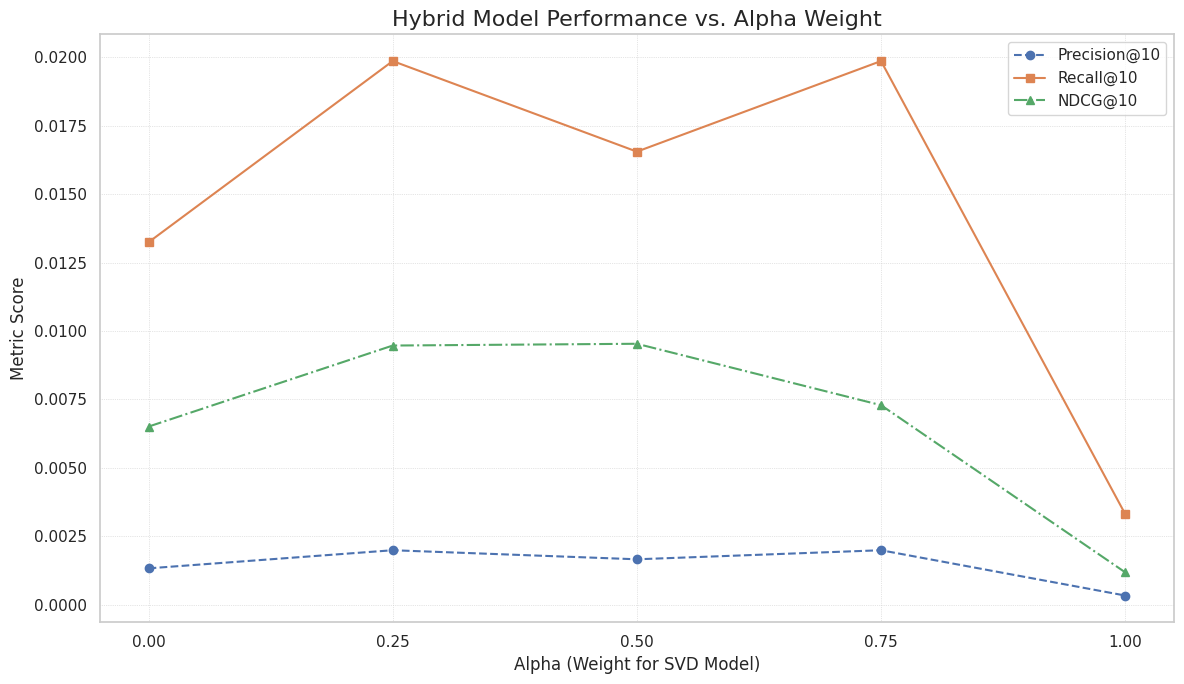

In [ ]:
# This script evaluates the hybrid model across different alpha weights and plots the performance.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Evaluation Function (Optimized for multiple runs) ---
def evaluate_hybrid_loo_fast(test_df, svd_model, ratings_df, alpha=0.7, k=10):
    all_svd_scores = svd_model.pu @ svd_model.qi.T
    s_min, s_max = all_svd_scores.min(), all_svd_scores.max()
    all_svd_scores_norm = (all_svd_scores - s_min) / (s_max - s_min) if (s_max - s_min) > 0 else 0
    precisions, recalls, ndcgs = [], [], []

    for _, row in test_df.iterrows():
        user_id = int(row['userId'])
        relevant = [int(row['movieId'])]
        try:
            inner_uid = svd_model.trainset.to_inner_uid(user_id)
        except ValueError:
            continue

        user_svd_scores_norm = all_svd_scores_norm[inner_uid]
        user_ratings = ratings_df[ratings_df['userId'] == user_id]
        liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
        if len(liked_movies) == 0:
            liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values

        if liked_movies.size > 0:
            liked_indices = [movie_id_to_index.get(mid) for mid in liked_movies if mid in movie_id_to_index]
            if liked_indices:
                content_scores = genre_similarity[liked_indices].mean(axis=0)
                c_min, c_max = content_scores.min(), content_scores.max()
                content_scores_norm = (content_scores - c_min) / (c_max - c_min) if (c_max - c_min) > 0 else 0
                hybrid_scores = alpha * user_svd_scores_norm + (1 - alpha) * content_scores_norm
                rated_indices = [movie_id_to_index.get(mid) for mid in user_ratings['movieId'].values if mid in movie_id_to_index]
                hybrid_scores[rated_indices] = -1
                recommended = [index_to_movie_id[i] for i in np.argsort(hybrid_scores)[::-1][:k]]
            else: # Fallback if no liked movies found in the index
                recommended = [svd_model.trainset.to_raw_iid(i) for i in np.argsort(user_svd_scores_norm)[::-1][:k]]
        else: # Fallback if user has no liked movies
             recommended = [svd_model.trainset.to_raw_iid(i) for i in np.argsort(user_svd_scores_norm)[::-1][:k]]

        precisions.append(precision_at_k(recommended, relevant, k))
        recalls.append(recall_at_k(recommended, relevant, k))
        ndcgs.append(ndcg_at_k(recommended, relevant, k))

    return {"Precision@K": np.mean(precisions), "Recall@K": np.mean(recalls), "NDCG@K": np.mean(ndcgs)}

# --- Run evaluation for different alpha values ---
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0.0 is pure Content-Based, 1.0 is pure SVD
all_metrics_alpha = []
print("Running evaluation for different alpha values...")

for a in alphas:
    print(f"  Evaluating for alpha = {a}...")
    metrics = evaluate_hybrid_loo_fast(loo_test, svd_loo, train_ratings, alpha=a, k=10)
    metrics['alpha'] = a
    all_metrics_alpha.append(metrics)

print("Finished all alpha evaluations.")
alpha_df = pd.DataFrame(all_metrics_alpha)

# --- Plot the results ---
plt.figure(figsize=(12, 7))
plt.plot(alpha_df['alpha'], alpha_df['Precision@K'], marker='o', linestyle='--', label='Precision@10')
plt.plot(alpha_df['alpha'], alpha_df['Recall@K'], marker='s', linestyle='-', label='Recall@10')
plt.plot(alpha_df['alpha'], alpha_df['NDCG@K'], marker='^', linestyle='-.', label='NDCG@10')

plt.title('Hybrid Model Performance vs. Alpha Weight', fontsize=16)
plt.xlabel('Alpha (Weight for SVD Model)', fontsize=12)
plt.ylabel('Metric Score', fontsize=12)
plt.xticks(alphas)
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

# **Phase 5 : Building the Streamlit Web App**

### Step 1 : TRAIN FINAL MODEL AND SAVE ALL ASSETS

In [17]:
# This script trains the models on all data and saves the components for the app.
# ==============================================================================

# --- Imports ---
from surprise import SVD, Dataset, Reader
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import pandas as pd
import numpy as np

# --- 1. Train the Final SVD Model on ALL Data ---
print("Training a final SVD model on the full dataset...")
reader = Reader(rating_scale=(1, 5))
full_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
final_trainset = full_data.build_full_trainset()

svd_final = SVD(random_state=42)
svd_final.fit(final_trainset)
print("SVD model trained.")

# --- 2. Build Final Content-Based & Hybrid Components ---
print("Building final content-based and hybrid components...")
# Align the movies DataFrame with the items the final SVD model knows about
final_movie_ids = [final_trainset.to_raw_iid(i) for i in range(final_trainset.n_items)]
movies_train = movies[movies['movieId'].isin(final_movie_ids)].reset_index(drop=True)

# Create all the necessary variables that the recommendation functions will need
movie_id_to_index = {mid: idx for idx, mid in enumerate(movies_train['movieId'])}
index_to_movie_id = {idx: mid for mid, idx in movie_id_to_index.items()}
movie_ids_array = movies_train['movieId'].values
genre_matrix = movies_train['genres'].str.get_dummies(sep='|')
genre_similarity = cosine_similarity(genre_matrix)
print("All components are ready.")

# --- 3. Save Everything to a File ---
print("\nSaving assets to file...")
# Create a dictionary to hold all the objects needed for the Streamlit app
recommender_assets = {
    'svd_model': svd_final,
    'movies_df': movies_train,
    'ratings_df': ratings, # The full ratings df for building user profiles
    'genre_similarity_matrix': genre_similarity,
    'movie_id_to_index_map': movie_id_to_index,
    'index_to_movie_id_map': index_to_movie_id,
    'movie_ids_array': movie_ids_array
}

# Save the dictionary using joblib
joblib.dump(recommender_assets, 'recommender_assets.joblib')

print("✅ Assets saved successfully to 'recommender_assets.joblib'!")

Training a final SVD model on the full dataset...
SVD model trained.
Building final content-based and hybrid components...
All components are ready.

Saving assets to file...
✅ Assets saved successfully to 'recommender_assets.joblib'!


### Step 2 : Making app.py

In [18]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.7 MB/s eta 0:00:00


In [19]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# =====================================================================================
# LOAD SAVED ASSETS (This is the file you created in Step 6.1)
# =====================================================================================
try:
    assets = joblib.load('recommender_assets.joblib')
    svd_model = assets['svd_model']
    movies_df = assets['movies_df']
    ratings_df = assets['ratings_df']
    genre_similarity_matrix = assets['genre_similarity_matrix']
    movie_id_to_index_map = assets['movie_id_to_index_map']
    index_to_movie_id_map = assets['index_to_movie_id_map']
    movie_ids_array = assets['movie_ids_array']
    print("Assets loaded successfully.")
except FileNotFoundError:
    st.error("Saved assets file not found! Please run the notebook step to generate 'recommender_assets.joblib'.")
    st.stop()


# =====================================================================================
# RECOMMENDATION FUNCTIONS
# =====================================================================================
def fast_content_recommendations(user_id, ratings_df, n=10):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0: liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values
    if len(liked_movies) == 0: return []

    liked_indices = [movie_id_to_index_map.get(mid) for mid in liked_movies if mid in movie_id_to_index_map]
    if not liked_indices: return []

    sim_scores = genre_similarity_matrix[liked_indices].mean(axis=0)

    rated_indices = [movie_id_to_index_map.get(mid) for mid in user_ratings['movieId'].values if mid in movie_id_to_index_map]
    sim_scores[rated_indices] = -1

    top_indices = np.argsort(sim_scores)[::-1][:n]
    return [index_to_movie_id_map[i] for i in top_indices]

def fast_hybrid_recommendations(user_id, svd_model, ratings_df, alpha=0.5, n=10):
    try:
        inner_uid = svd_model.trainset.to_inner_uid(user_id)
    except ValueError:
        return fast_content_recommendations(user_id, ratings_df, n=n)

    user_vector = svd_model.pu[inner_uid]
    item_vectors = svd_model.qi
    svd_scores = user_vector @ item_vectors.T + svd_model.bi + svd_model.bu[inner_uid] + svd_model.trainset.global_mean

    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    liked_movies = user_ratings[user_ratings['rating'] >= 4]['movieId'].values
    if len(liked_movies) == 0: liked_movies = user_ratings[user_ratings['rating'] >= 3]['movieId'].values

    if len(liked_movies) > 0:
        liked_indices = [movie_id_to_index_map.get(mid) for mid in liked_movies if mid in movie_id_to_index_map]
        if liked_indices:
            content_scores = genre_similarity_matrix[liked_indices].mean(axis=0)

            s_min, s_max = svd_scores.min(), svd_scores.max()
            c_min, c_max = content_scores.min(), content_scores.max()

            norm_svd = (svd_scores - s_min) / (s_max - s_min) if (s_max - s_min) > 0 else 0
            norm_content = (content_scores - c_min) / (c_max - c_min) if (c_max - c_min) > 0 else 0

            hybrid_scores = alpha * norm_svd + (1 - alpha) * norm_content

            rated_indices = [movie_id_to_index_map.get(mid) for mid in user_ratings['movieId'].values if mid in movie_id_to_index_map]
            hybrid_scores[rated_indices] = -1

            top_indices = np.argsort(hybrid_scores)[::-1][:n]
            return [index_to_movie_id_map[i] for i in top_indices]

    # Fallback to pure SVD if content profile is empty
    rated_movies = user_ratings['movieId'].unique()
    unrated_movies = movies_df[~movies_df['movieId'].isin(rated_movies)]['movieId'].tolist()
    predictions = [svd_model.predict(user_id, mid) for mid in unrated_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    return [pred.iid for pred in predictions[:n]]

# =====================================================================================
# STREAMLIT APP UI
# =====================================================================================

st.set_page_config(layout="wide", page_title="Movie Recommender")

st.title('🎬 Hybrid Movie Recommender')
st.write("This app recommends movies using a model trained on the MovieLens 1M dataset.")

# --- User Input ---
st.sidebar.header('Enter Your User ID')
user_id_input = st.sidebar.number_input('User ID (1 to 6040)', min_value=1, max_value=6040, value=12, step=1)

# --- Generate Recommendations ---
if st.sidebar.button('Get Recommendations'):
    with st.spinner('Finding movies you might like...'):
        recommended_movie_ids = fast_hybrid_recommendations(
            user_id=user_id_input,
            svd_model=svd_model,
            ratings_df=ratings_df,
            alpha=0.5,
            n=10
        )

        if recommended_movie_ids:
            st.subheader(f'Top 10 Recommendations for User {user_id_input}')

            recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]
            st.table(recommended_movies[['title', 'genres']])
        else:
            st.error("Could not generate recommendations for this user. They may have too few ratings.")

Writing app.py


# **Note : app.py will be updated in github**

### Requirement.txt

In [ ]:
%%writefile requirements.txt
# A comment to force a rebuild
streamlit
pandas
numpy
joblib
scikit-learn
scikit-surprise

### Create a Configuration File to Prevent Errors

### Downloads

In [ ]:
from google.colab import files

print("Downloading the four essential files for your app...")

# Download the main app script
files.download('app.py')

# Download the requirements file
files.download('requirements.txt')

# Download the saved model and data assets
files.download('recommender_assets.joblib')

# Download the configuration file
# Note: You will need to create the .streamlit folder on Hugging Face when you upload this
files.download('.streamlit/config.toml')

print("\nAll files downloaded! You are now ready to upload them to Hugging Face.")